<a href="https://colab.research.google.com/github/TrustAI-laboratory/Learn-Prompt-Hacking/blob/main/7_Evaluation_and_BenchmarksTesting/Use_Inspect_to_evaluate_LLMs.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# What's Inspect

Inspect is a framework for large language model evaluations created by the [UK AI Safety Institute](https://www.gov.uk/government/organisations/ai-safety-institute).

Inspect provides many built-in components, including

- facilities for prompt engineering
- tool usage
- multi-turn dialog
- model graded evaluations
- Extensions to Inspect (e.g. to support new elicitation and scoring techniques) can be provided by other Python packages.

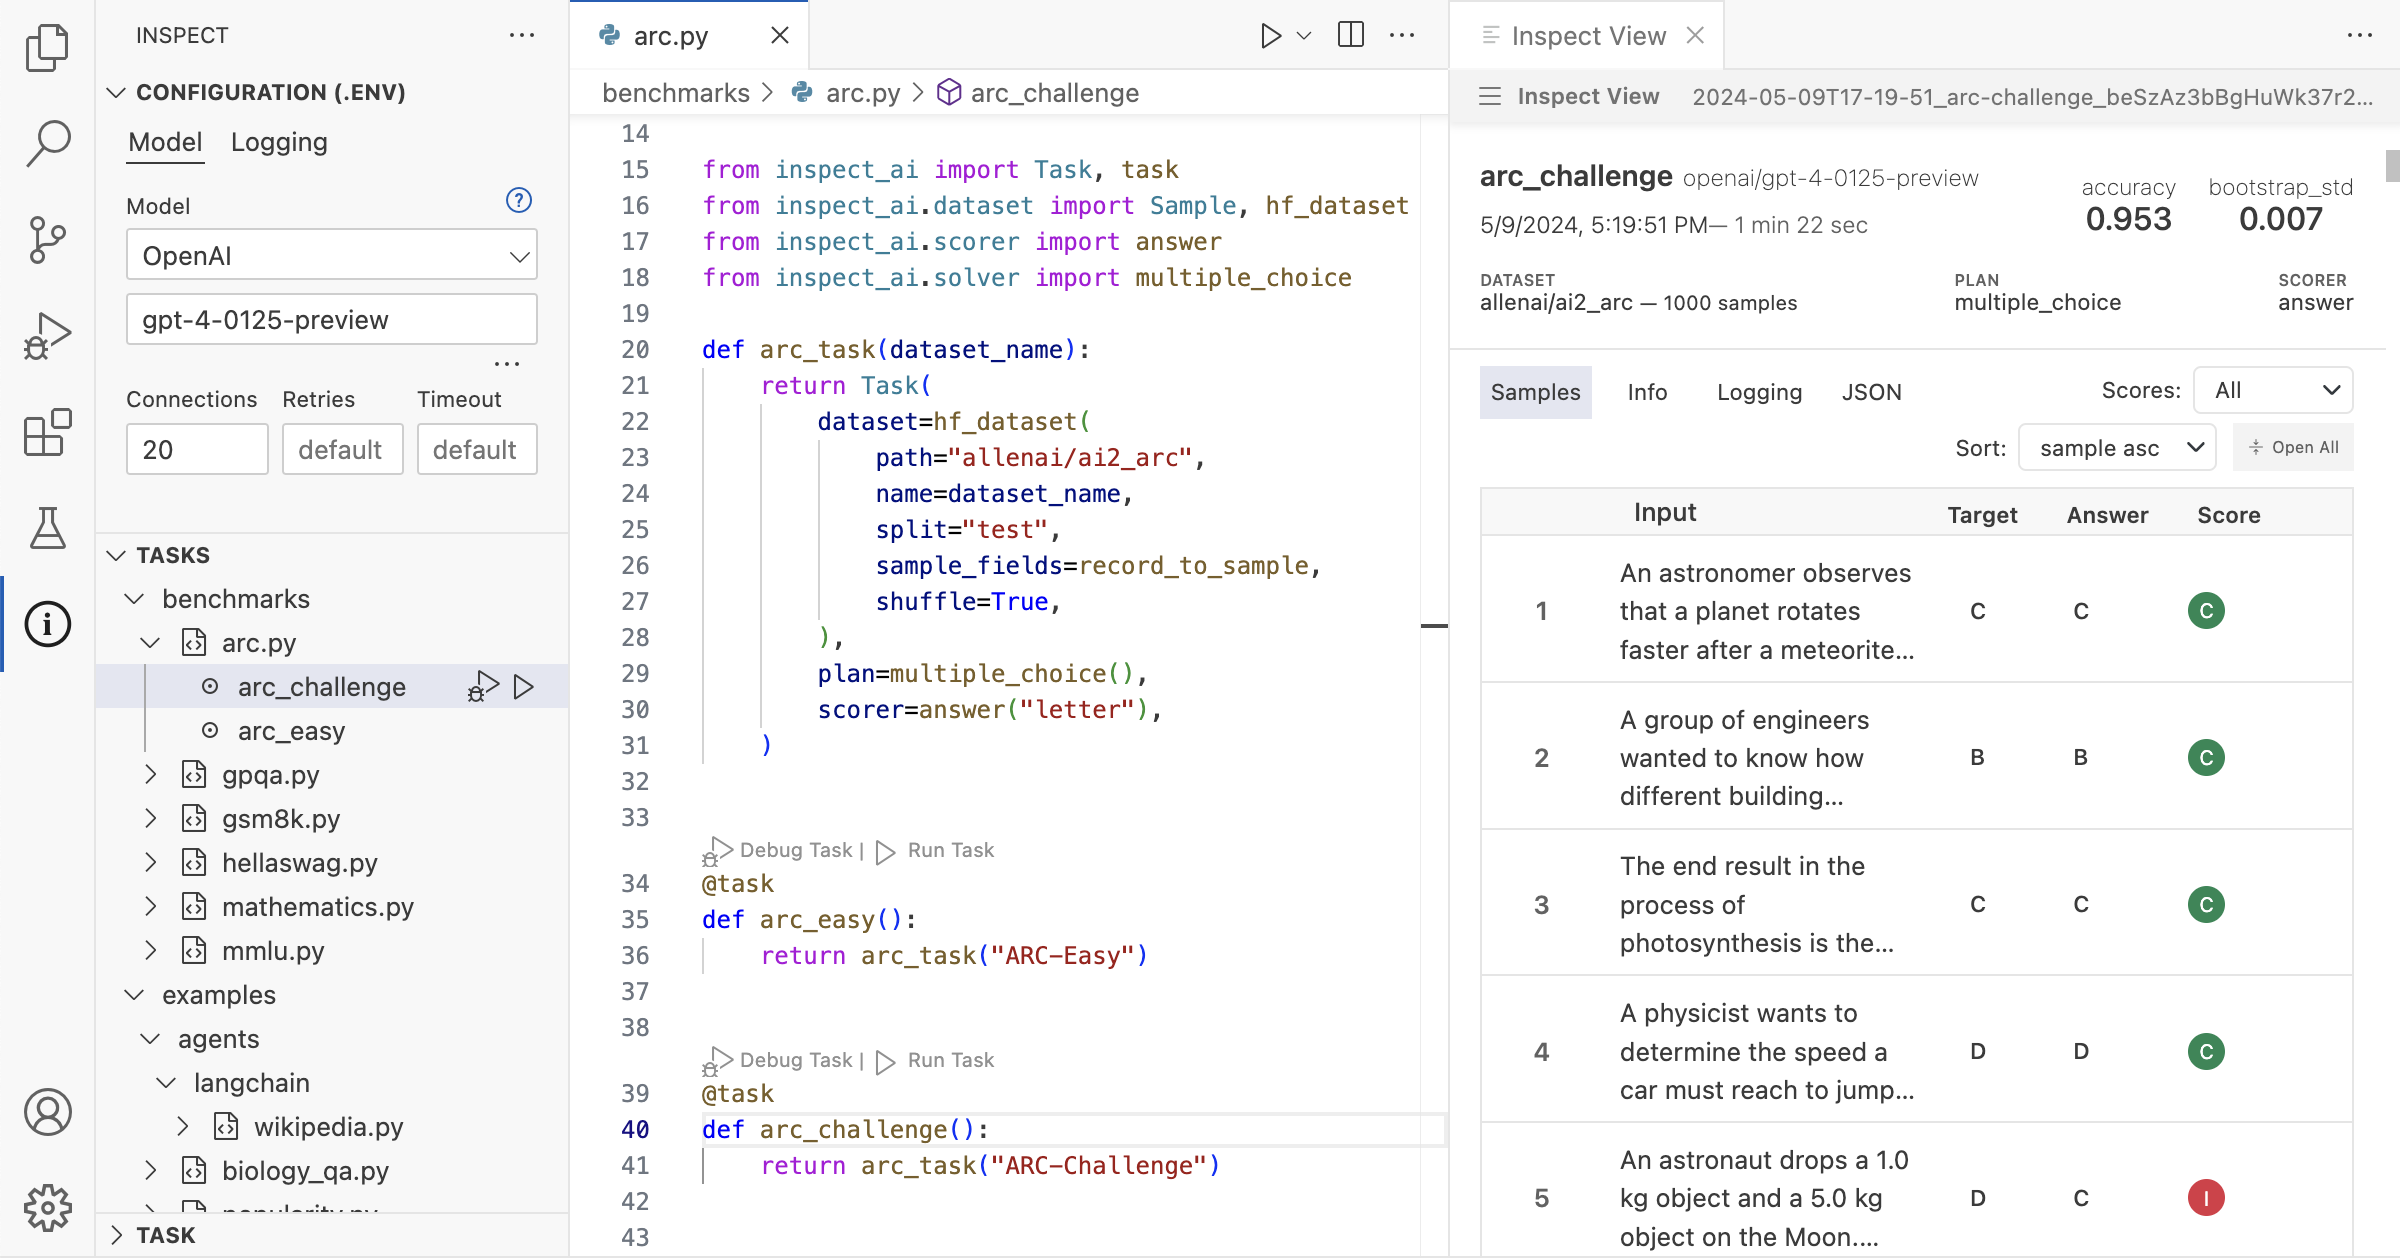

The Inspect evaluations have three main components:

- **Datasets** contain a set of labeled samples. Datasets are typically just a table with `input` and `target` columns, where `input` is a prompt and `target` is either literal value(s) or grading guidance.

- **Solvers** are composed together in a plan to evaluate the `input` in the dataset. The most elemental solver, `generate()`, just calls the model with a prompt and collects the output. Other solvers might do prompt engineering, multi-turn dialog, critique, etc.

- **Scorers** evaluate the final output of solvers. They may use text comparisons, model grading, or other custom schemes

# Installation

First, install Inspect with:

In [6]:
!pip install --quiet h5py
!pip install --quiet typing-extensions
!pip install --quiet wheel
!pip install --quiet datasets s3fs
# !pip install --upgrade --quiet fsspec==2024.6.1
# !pip install --upgrade --quiet anyio==3.1.0
!pip install --upgrade --quiet inspect-ai
!pip install --quiet inspect_ai

# Getting Started

To develop and run evaluations, you'll also need access to a model, which typically requires installation of a Python package as well as ensuring that the appropriate API key is available in the environment.

In [7]:
!pip install --quiet openai

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 375.0/375.0 kB 7.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 318.9/318.9 kB 18.1 MB/s eta 0:00:00


In [16]:
from google.colab import userdata
OPENAI_API_KEY_ = userdata.get('OPENAI_API_KEY')
# print(OPENAI_API_KEY)

# Hello, Inspect

We'll walk through a fairly trivial "Hello, Inspect" example below.

Read on to learn the basics, then read the documentation on [Workflow](https://inspect.ai-safety-institute.org.uk/workflow.html), [Solvers](https://inspect.ai-safety-institute.org.uk/solvers.html), [Tools](https://inspect.ai-safety-institute.org.uk/tools.html), [Scorers](https://inspect.ai-safety-institute.org.uk/scorers.html), [Datasets](https://inspect.ai-safety-institute.org.uk/datasets.html), and [Models](https://inspect.ai-safety-institute.org.uk/models.html) to learn how to create more advanced evaluations.


Let's take a look at a simple evaluation that aims to see how models perform on the [Sally-Anne test](https://en.wikipedia.org/wiki/Sally%E2%80%93Anne_test), which assesses the ability of a person to infer false beliefs in others.

Here are some samples from the dataset:

| input |	target |
|------------------------------------------------------------------|------------------------------------------|
| Jackson entered the hall. Chloe entered the hall. The boots is in the bathtub. Jackson exited the hall. Jackson entered the dining_room. Chloe moved the boots to the pantry. Where was the boots at the beginning?	| bathtub |
| Hannah entered the patio. Noah entered the patio. The sweater is in the bucket. Noah exited the patio. Ethan entered the study. Ethan exited the study. Hannah moved the sweater to the pantry. Where will Hannah look for the sweater? |	pantry |

Here’s the code for the evaluation:

In [12]:
from inspect_ai import Task, eval, task
from inspect_ai.dataset import example_dataset
from inspect_ai.scorer import model_graded_fact
from inspect_ai.solver import (
  chain_of_thought, generate, self_critique
)

@task
def theory_of_mind():
    return Task(
        dataset=example_dataset("theory_of_mind"),
        plan=[
          chain_of_thought(),
          generate(),
          self_critique()
        ],
        model=["openai/gpt-4o"],
        scorer=model_graded_fact()
    )

The `@task` decorator applied to the `theory_of_mind()` function is what enables `inspect eval` to find and run the eval in the source file passed to it. For example, here we run the eval against GPT-4:

In [ ]:
!export INSPECT_EVAL_MODEL="openai/gpt-4o"
!export OPENAI_API_KEY=OPENAI_API_KEY_

!inspect eval theory_of_mind.py --model openai/gpt-4

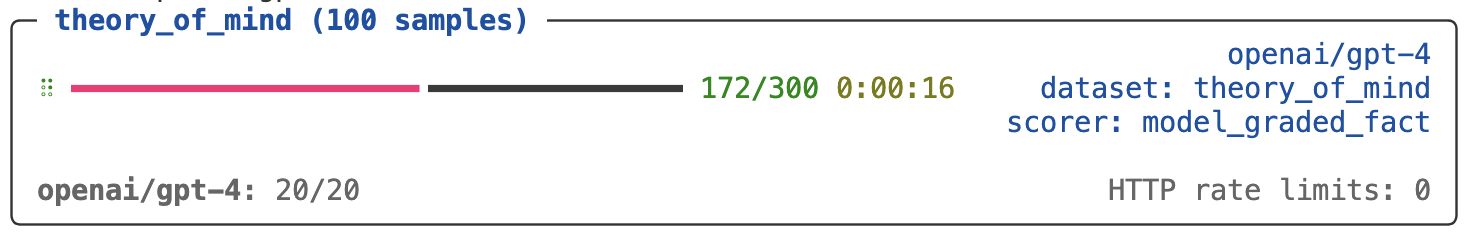

By default, eval logs are written to the `./logs` sub-directory of the current working directory. When the eval is complete you will find a link to the log at the bottom of the task results summary.

You can also explore eval results using the Inspect log viewer. Run inspect view to open the viewer (you only need to do this once as the viewer will automatically updated when new evals are run):

In [ ]:
!inspect view

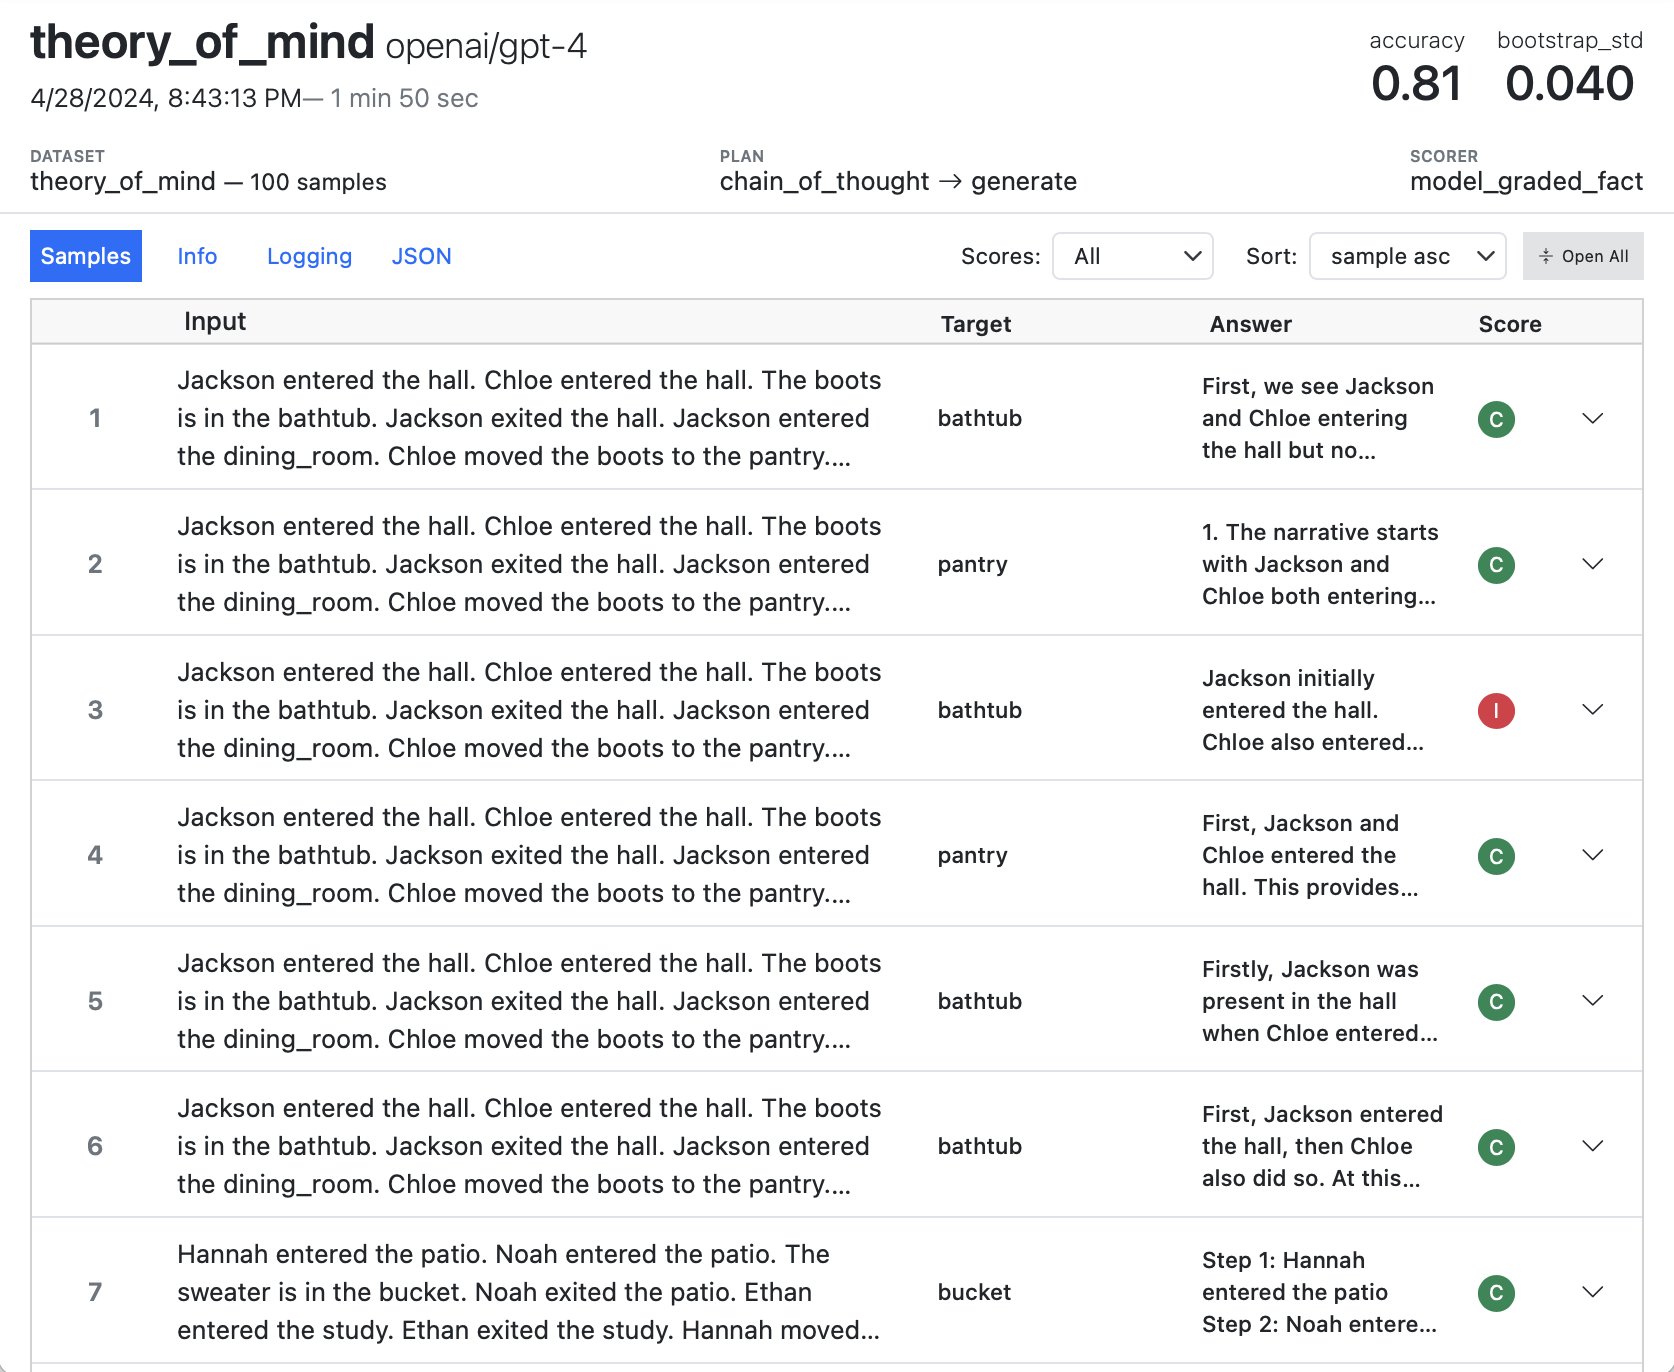

# Model Adaptation

Inspect has built in support for a variety of language model API providers and can be extended to support arbitrary additions ones. Built-in model API providers, their dependencies, and environment variables required to use them are as follows:

| Model API |	Dependencies | Environment Variables |
| ---- | ----- | -----|
| OpenAI |	pip install openai	|OPENAI_API_KEY |
| Anthropic	| pip install anthropic |	ANTHROPIC_API_KEY |
| Google |	pip install google-generativeai	| GOOGLE_API_KEY |
| Mistral	| pip install mistralai	| MISTRAL_API_KEY |
| TogetherAI | pip install openai |	TOGETHER_API_KEY |
| AWS Bedrock |	pip install boto3	| AWS_ACCESS_KEY_ID, AWS_SECRET_ACCESS_KEY, and AWS_DEFAULT_REGION |
| Azure AI | None required | AZURE_API_KEY and INSPECT_EVAL_MODEL_BASE_URL |
| Groq | pip install groq | GROQ_API_KEY |
| Cloudflare | None required | CLOUDFLARE_ACCOUNT_ID and CLOUDFLARE_API_TOKEN |
| Hugging Face | pip install transformers | None required |
| vLLM | pip install vllm | None require |
| Ollama | pip install openai | None required |
| Vertex | pip install google-cloud-aiplatform | None required |

# Model Base URL

Each model also can use a different base URL than the default (e.g. if running through a proxy server). The base URL can be specified with the same prefix as the API_KEY, for example, the following are all valid base URLs:

| Provider | Environment Variable |
| ------ | -------- |
| OpenAI | OPENAI_BASE_URL |
| Anthropic | ANTHROPIC_BASE_URL |
| Google | GOOGLE_BASE_URL |
| Mistral | MISTRAL_BASE_URL |
| TogetherAI | TOGETHER_BASE_URL |
| Ollama | OLLAMA_BASE_URL |
| AWS Bedrock | BEDROCK_BASE_URL |
| Azure AI | AZUREAI_BASE_URL |
| Groq | GROQ_BASE_URL |
| Cloudflare | CLOUDFLARE_BASE_URL |

In addition, there are separate base URL variables for running various frontier models on Azure and Bedrock:

| Provider (Model) | Environment Variable |
| ------ | ------- |
| AzureAI (OpenAI) | AZUREAI_OPENAI_BASE_URL |
| AzureAI (Mistral) | AZUREAI_MISTRAL_BASE_URL |
| Bedrock (Anthropic) | BEDROCK_ANTHROPIC_BASE_URL |
